# Run experiments

In this notebook we run the experiments that are shown in Tables 2, 3, 4, and 5.

- Table 2 results in `results/test_all_1_formatted.csv`
- Table 3 results in `results/test_perBA_1_formatted.csv`
- Table 4 results in `results/test_all_0_formatted.csv`
- Table 5 results in `results/test_perBA_0_formatted.csv`

In [1]:
%matplotlib inline
import sys
import os
import time

import pandas as pd
import numpy as np

import CBECSLib

import itertools
from collections import defaultdict, Counter

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

#sklearn base
import sklearn.base

#sklearn utility
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

#IPython utilities
from IPython.display import HTML,display
def show(html):
    display(HTML(html))

In [2]:
RESULTS_DIR = "results/" # where output is written to
DATASET = 1 # for the extended set of features use 0, for the common set of features use 1

In [3]:
pbaLabels = CBECSLib.pbaLabels
pbaPlusLabels = CBECSLib.pbaPlusLabels

getDataset = CBECSLib.getDataset
getClassFrequencies = CBECSLib.getClassFrequencies
getDataSubset = CBECSLib.getDataSubset

## Create Regression Models

In [4]:
regressors = CBECSLib.regressors
regressorNames = CBECSLib.regressorNames
numRegressors = CBECSLib.numRegressors

metrics = CBECSLib.metrics
metricNames = CBECSLib.metricNames
numMetrics = CBECSLib.numMetrics

# Experiments Training on All Data, Testing Per PBA

In [5]:
X,Y,columnNames,classVals = getDataset(DATASET,pbaOneHot=True)
classOrdering,classFrequencies = getClassFrequencies(classVals)
numClassVals = len(classFrequencies)
Y = np.log10(Y)

numSplits = 10
numRepeats = 10
outputFn = "test_perPBA_%d" % (DATASET)

results = np.zeros((numRepeats, numSplits, numRegressors, numClassVals, numMetrics), dtype=float)

for i in range(numRepeats):
    print "Repetition %d" % (i)

    kf = StratifiedKFold(n_splits=numSplits)
    for j, (train, test) in enumerate(kf.split(X,classVals)):
        #print "\tSplit %d" % (j)
        X_train, X_test = X[train,:], X[test,:]
        Y_train, Y_test = Y[train], Y[test]
        classVals_train, classVals_test = classVals[train].copy(), classVals[test].copy()

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        for k in range(numRegressors):
            regressor = sklearn.base.clone(regressors[k])
            regressorName = regressorNames[k]

            #train model
            regressor.fit(X_train,Y_train)

            for l,classVal in enumerate(classOrdering):

                className = pbaLabels[classVal]
                numberOfSamples = classFrequencies[classVal]

                X_temp, Y_temp = getDataSubset(X_test,Y_test,classVals_test,classVal)

                #predict model
                predicted = regressor.predict(X_temp)
                predicted[predicted<0] = 0

                #evaluate model
                for m,metric in enumerate(metrics):
                    metricName = metricNames[m]
                    score = metric(Y_temp,predicted)
                    results[i,j,k,l,m] = score
        
results = np.array(results)

metricIndex = 4
results = results.reshape(-1, numRegressors, numClassVals, numMetrics)

classNames = [pbaLabels[pbaLabel] for pbaLabel in classOrdering]

meanResults = results.mean(axis=0)
meanResultTable = pd.DataFrame(meanResults[:,:,metricIndex], index=regressorNames, columns=classNames)
meanResultTable.to_csv(os.path.join(RESULTS_DIR, "%s_means.csv" % (outputFn)))

stdResults = results.std(axis=0)
stdResultTable = pd.DataFrame(stdResults[:,:,metricIndex], index=regressorNames, columns=classNames)
stdResultTable.to_csv(os.path.join(RESULTS_DIR, "%s_stds.csv" % (outputFn)))

formattedResults = []
for i in range(numRegressors):
    row = []
    for j in range(numClassVals):
        row.append("%0.2f +/- %0.2f" % (meanResults[i,j,metricIndex], stdResults[i,j,metricIndex]))
    formattedResults.append(row)
formattedResults = np.array(formattedResults)
formattedResultsTable = pd.DataFrame(formattedResults.T, index=classNames, columns=regressorNames)
formattedResultsTable.to_csv(os.path.join(RESULTS_DIR, "%s_formatted.csv" % (outputFn)))

display(formattedResultsTable)

20 classes
Repetition 0
Repetition 1
Repetition 2
Repetition 3
Repetition 4
Repetition 5
Repetition 6
Repetition 7
Repetition 8
Repetition 9


,Linear Regression,Ridge Regressor,SVR,Lasso,ElasticNet,Linear SVR,AdaBoost,Bagging,XGBoost,Random Forest Regressor,Extra Trees Regressor,MLP Regressor,KNN Regressor
Office,0.45 +/- 0.05,0.45 +/- 0.05,0.77 +/- 0.03,-0.00 +/- 0.00,0.11 +/- 0.02,0.43 +/- 0.07,0.82 +/- 0.05,0.86 +/- 0.03,0.88 +/- 0.02,0.86 +/- 0.03,0.85 +/- 0.03,0.84 +/- 0.03,0.70 +/- 0.05
Education,0.37 +/- 0.05,0.37 +/- 0.05,0.68 +/- 0.06,-0.17 +/- 0.11,-0.12 +/- 0.10,0.38 +/- 0.07,0.75 +/- 0.08,0.80 +/- 0.04,0.84 +/- 0.03,0.80 +/- 0.04,0.80 +/- 0.04,0.80 +/- 0.04,0.64 +/- 0.10
Nonrefrigerated warehouse,0.31 +/- 0.07,0.31 +/- 0.07,0.50 +/- 0.07,-0.18 +/- 0.07,-0.10 +/- 0.09,0.33 +/- 0.07,0.43 +/- 0.15,0.55 +/- 0.11,0.63 +/- 0.06,0.55 +/- 0.11,0.55 +/- 0.09,0.59 +/- 0.05,0.47 +/- 0.10
Service,0.08 +/- 0.10,0.08 +/- 0.10,0.22 +/- 0.12,-1.17 +/- 0.53,-1.06 +/- 0.50,0.08 +/- 0.09,0.30 +/- 0.17,0.23 +/- 0.21,0.37 +/- 0.16,0.23 +/- 0.22,0.12 +/- 0.24,0.31 +/- 0.12,-0.04 +/- 0.23
Religious worship,0.12 +/- 0.09,0.12 +/- 0.08,0.33 +/- 0.15,-1.01 +/- 0.71,-0.91 +/- 0.65,0.12 +/- 0.12,0.53 +/- 0.12,0.44 +/- 0.24,0.57 +/- 0.16,0.45 +/- 0.21,0.40 +/- 0.29,0.46 +/- 0.10,0.13 +/- 0.19
Retail other than mall,0.17 +/- 0.11,0.17 +/- 0.11,0.59 +/- 0.13,-0.27 +/- 0.23,-0.20 +/- 0.22,0.21 +/- 0.11,0.62 +/- 0.13,0.70 +/- 0.12,0.73 +/- 0.11,0.69 +/- 0.12,0.69 +/- 0.12,0.68 +/- 0.11,0.35 +/- 0.19
Public assembly,0.42 +/- 0.10,0.42 +/- 0.10,0.64 +/- 0.08,-0.02 +/- 0.02,0.09 +/- 0.04,0.44 +/- 0.10,0.76 +/- 0.04,0.77 +/- 0.04,0.81 +/- 0.03,0.77 +/- 0.04,0.73 +/- 0.07,0.75 +/- 0.06,0.58 +/- 0.14
Food service,-0.04 +/- 0.05,-0.04 +/- 0.05,0.02 +/- 0.07,-0.07 +/- 0.06,-0.05 +/- 0.04,-0.05 +/- 0.06,-1.97 +/- 1.46,-0.07 +/- 0.36,0.20 +/- 0.12,-0.05 +/- 0.32,-0.15 +/- 0.39,0.07 +/- 0.08,-0.18 +/- 0.21
Strip shopping mall,0.32 +/- 0.07,0.32 +/- 0.06,0.55 +/- 0.09,-1.06 +/- 0.46,-1.02 +/- 0.43,0.34 +/- 0.12,-0.01 +/- 0.30,0.67 +/- 0.12,0.73 +/- 0.09,0.67 +/- 0.13,0.66 +/- 0.11,0.70 +/- 0.08,0.50 +/- 0.15
Lodging,0.40 +/- 0.15,0.40 +/- 0.16,0.68 +/- 0.20,-0.68 +/- 0.48,-0.50 +/- 0.44,0.28 +/- 0.28,0.63 +/- 0.14,0.80 +/- 0.11,0.83 +/- 0.11,0.80 +/- 0.11,0.81 +/- 0.12,0.77 +/- 0.14,0.60 +/- 0.24


# Experiments Training on All Data, Testing on All Data

In [6]:
X,Y,columnNames,classVals = getDataset(DATASET,pbaOneHot=True)
classOrdering,classFrequencies = getClassFrequencies(classVals)
numClassVals = len(classFrequencies)
Y = np.log10(Y)

numSplits = 10
numRepeats = 10
outputFn = "test_all_%d" % (DATASET)

results = np.zeros((numRepeats, numSplits, numRegressors, numMetrics), dtype=float)

for i in range(numRepeats):
    print "Repetition %d" % (i)

    kf = StratifiedKFold(n_splits=numSplits)
    for j, (train, test) in enumerate(kf.split(X,classVals)):
        #print "\tSplit %d" % (j)
        X_train, X_test = X[train,:], X[test,:]
        Y_train, Y_test = Y[train], Y[test]
        classVals_train, classVals_test = classVals[train].copy(), classVals[test].copy()

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        for k in range(numRegressors):
            regressor = sklearn.base.clone(regressors[k])
            regressorName = regressorNames[k]

            #train model
            regressor.fit(X_train,Y_train)

            #predict model
            predicted = regressor.predict(X_test)
            predicted[predicted<0] = 0

            #evaluate model
            for m,metric in enumerate(metrics):
                metricName = metricNames[m]
                score = metric(Y_test,predicted)
                results[i,j,k,m] = score
        
results = np.array(results)

results = results.reshape(-1, numRegressors, numMetrics)

classNames = [pbaLabels[pbaLabel] for pbaLabel in classOrdering]

meanResults = results.mean(axis=0)
meanResultTable = pd.DataFrame(meanResults, index=regressorNames, columns=metricNames)
meanResultTable.to_csv(os.path.join(RESULTS_DIR, "%s_means.csv" % (outputFn)))

stdResults = results.std(axis=0)
stdResultTable = pd.DataFrame(stdResults, index=regressorNames, columns=metricNames)
stdResultTable.to_csv(os.path.join(RESULTS_DIR, "%s_stds.csv" % (outputFn)))

formattedResults = []
for i in range(numRegressors):
    row = []
    for j in range(numMetrics):
        row.append("%0.2f +/- %0.2f" % (meanResults[i,j], stdResults[i,j]))
    formattedResults.append(row)
formattedResults = np.array(formattedResults)
formattedResultsTable = pd.DataFrame(formattedResults, index=regressorNames, columns=metricNames)
formattedResultsTable.to_csv(os.path.join(RESULTS_DIR, "%s_formatted.csv" % (outputFn)))

display(formattedResultsTable)

20 classes
Repetition 0
Repetition 1
Repetition 2
Repetition 3
Repetition 4
Repetition 5
Repetition 6
Repetition 7
Repetition 8
Repetition 9


,Mean Absolute Error,10^Mean AE,Median Absolute Error,10^Median AE,$r^2$
Linear Regression,0.52 +/- 0.02,3.33 +/- 0.13,0.43 +/- 0.02,2.72 +/- 0.12,0.53 +/- 0.03
Ridge Regressor,0.52 +/- 0.02,3.33 +/- 0.13,0.43 +/- 0.02,2.72 +/- 0.12,0.53 +/- 0.03
SVR,0.39 +/- 0.01,2.44 +/- 0.07,0.29 +/- 0.01,1.95 +/- 0.04,0.70 +/- 0.03
Lasso,0.79 +/- 0.02,6.17 +/- 0.35,0.69 +/- 0.03,4.92 +/- 0.38,-0.00 +/- 0.00
ElasticNet,0.76 +/- 0.02,5.75 +/- 0.32,0.67 +/- 0.03,4.67 +/- 0.35,0.09 +/- 0.01
Linear SVR,0.52 +/- 0.02,3.28 +/- 0.15,0.40 +/- 0.02,2.54 +/- 0.12,0.51 +/- 0.04
AdaBoost,0.43 +/- 0.03,2.71 +/- 0.16,0.36 +/- 0.03,2.30 +/- 0.16,0.68 +/- 0.04
Bagging,0.33 +/- 0.02,2.12 +/- 0.07,0.24 +/- 0.01,1.72 +/- 0.05,0.78 +/- 0.02
XGBoost,0.30 +/- 0.01,1.99 +/- 0.06,0.22 +/- 0.01,1.66 +/- 0.03,0.82 +/- 0.02
Random Forest Regressor,0.33 +/- 0.01,2.12 +/- 0.07,0.24 +/- 0.01,1.73 +/- 0.04,0.78 +/- 0.02


## Visualize Regressor Errors

20 classes
Linear Regression
Training model 1/13	Linear Regression


IOError: [Errno 2] No such file or directory: 'results/errorPlots/Linear_Regression_errorPlot.png'

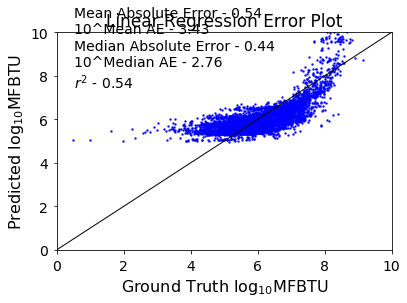

In [7]:
X,Y,columnNames,classVals = getDataset(DATASET,pbaOneHot=True)
classOrdering,classFrequencies = getClassFrequencies(classVals)
numClassVals = len(classFrequencies)
Y = np.log10(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_all_scaled = scaler.transform(X)

for i in range(numRegressors):
    regressor = sklearn.base.clone(regressors[i])
    regressorName = regressorNames[i]
    
    print regressorName
    #if regressorName != "XGBoost" and regressorName!= "Linear Regression":
    #    continue
    
    print "Training model %d/%d\t%s" % (i+1, len(regressors), regressorName)

    
    regressor.fit(X_train_scaled,Y_train)
    
    #predict model
    predicted = regressor.predict(X_test_scaled)
    predicted[predicted<0] = 0

    #evaluate model
    scores = []
    for l,metric in enumerate(metrics):
        metricName = metricNames[l]
        score = metric(Y_test,predicted)
        scores.append((metricName,score))
    
    predicted = regressor.predict(X_all_scaled)
    
    #----------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------
    
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    
    ax.scatter(Y, predicted, color='b', s=4, label="Predicted")
    
    ax.plot([0,10],[0,10], color='k', linewidth=1)
    
    displayString = []
    for metricName, score in scores:
        displayString.append("%s - %0.2f" % (metricName, score))
    displayString = '\n'.join(displayString)
    ax.text(0.5, 7.5, displayString, fontsize=14)

    #ax.set_xscale('symlog')
    #ax.set_yscale('symlog')

    ax.set_xlim([0,10])
    ax.set_ylim([0,10])
    
    ax.set_title("%s Error Plot" % (regressorName), fontsize=17)
    ax.set_xlabel("Ground Truth log$_{10}$MFBTU", fontsize=16)
    ax.set_ylabel("Predicted log$_{10}$MFBTU", fontsize=16)

    ax.tick_params(axis='both', which='major', labelsize=14)
    
    plt.savefig(os.path.join(RESULTS_DIR, "errorPlots/%s_errorPlot.png"  % (regressorName.replace(' ','_'))), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    #----------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------
    
    absoluteErrors = np.abs(Y - predicted)
    
    print "Min error: %f" % (absoluteErrors.min())
    print "Max error: %f" % (absoluteErrors.max())
    
    fig, ax = plt.subplots(1,1,figsize=(6,4))
        
    ax.set_title("%s Error Distribution" % (regressorName), fontsize=17)
    ax.set_xlabel("|actual - predicted|", fontsize=16)
    ax.set_ylabel("Frequency", fontsize=16)
        
    ax.hist(absoluteErrors, bins=np.linspace(0,5,30))
    ax.axvline(x=absoluteErrors.mean(), linewidth=2, color='k')
    
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.set_xlim([0,5])
    
    plt.savefig(os.path.join(RESULTS_DIR, "errorPlots/%s_errorDist.png"  % (regressorName.replace(' ','_'))), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    